In [1]:
import os
import sys
import random
import time
from random import seed, randint
import argparse
import platform
from datetime import datetime
import imp
import numpy as np
import fileinput
from itertools import product
import pandas as pd
from scipy.interpolate import griddata
from scipy.interpolate import interp2d
import seaborn as sns
from os import listdir

import matplotlib.pyplot as plt
import seaborn as sns
from scipy.interpolate import griddata
import matplotlib as mpl
# sys.path.insert(0,'..')
# from notebookFunctions import *
# from .. import notebookFunctions
from Bio.PDB.Polypeptide import one_to_three
from Bio.PDB.Polypeptide import three_to_one
from Bio.PDB.PDBParser import PDBParser
from pyCodeLib import *
# from small_script.myFunctions import *
sys.path.insert(0, "/Users/weilu/openmmawsem")
from helperFunctions.myFunctions import *
from collections import defaultdict
%matplotlib inline
# plt.rcParams['figure.figsize'] = (10,6.180)    #golden ratio
# %matplotlib notebook
%load_ext autoreload
%autoreload 2

In [2]:
plt.rcParams['figure.figsize'] = np.array([16.18033, 10])    #golden ratio
plt.rcParams['figure.facecolor'] = 'w'
plt.rcParams['figure.dpi'] = 100
plt.rcParams.update({'font.size': 22})

In [3]:
def mycp(source, target):
    os.system(f"cp {source} {target}")
    
do = os.system

def getSeq(fileLocation):
    p = PDBParser()
    s = p.get_structure("test", fileLocation)
    seq = ""
    residues = list(s.get_residues())
    for residue in residues:
        res_id = residue.get_id()[0]
        if res_id==' ':
            residue_name = residue.get_resname()
            seq += three_to_one(residue_name)
    return seq

# get chains nad seq
def getChainsAndSeq(fileLocation):
    # fileLocation = "/Users/weilu/Research/examples/optimization/optimization/Structure_Ensemble/1.pdb"
    p = PDBParser()
    pdb = p.get_structure("test", fileLocation)
    residues = list(pdb.get_residues())
    seq = ""
    chains = ""
    for residue in residues:
        res_id = residue.get_id()[0]
        chain = residue.get_full_id()[2]
        if res_id==' ':
            residue_name = residue.get_resname()
            seq += three_to_one(residue_name)
            chains += chain
    return chains, seq

In [ ]:
pdbFolderList = glob.glob("/Users/weilu/Dropbox/Optimization_Xfunnel/Structure_Ensemble_*")

In [4]:
pdbFolderList = glob.glob("/Users/weilu/Research/server/oct_2019/Database_Optimization/*")

In [5]:
len(pdbFolderList)

81

In [11]:
# filter out those has incompelete peptide.txt
_all = []
# generate decoys
protein_list = []
for pdbFolder in pdbFolderList:
#     pdbName = pdbFolder.split("_")[-1]
    pdbName = pdbFolder.split("/")[-1]
    source = pdbFolder + f"/*.pdb"
    p_list = glob.glob(source)
    # print(p_list, source)
#     assert len(p_list) == 1
    p = p_list[0]
    chain_seq, seq = getChainsAndSeq(p)
    
    # print(pdbName, i, len(seq), len(chain_seq))
    decoy_list = []
    if not os.path.exists(f"{pdbFolder}/peptide.txt"):
        print(pdbFolder, "not exist")
        continue
    with open(f"{pdbFolder}/peptide.txt") as f:
        for line in f:
            pep = line.strip()
            pep_len = len(pep)
            # assert len(pep) == 9
            for c in list(set(chain_seq)):
                if chain_seq.count(c) == pep_len:
                    first_c = chain_seq.find(c)
                    a = list(seq)
                    a[first_c:first_c+pep_len] = pep
                    assert len(set(chain_seq[first_c:first_c+pep_len])) == 1
                    decoy = "".join(a)
                    decoy_list.append(decoy)
    _all.append([pdbName, len(decoy_list)])

/Users/weilu/Research/server/oct_2019/Database_Optimization/NLV2_4Sep_AWSEM not exist
/Users/weilu/Research/server/oct_2019/Database_Optimization/MART1_3QDG_AWSEM not exist
/Users/weilu/Research/server/oct_2019/Database_Optimization/NLV3_4Sep_AWSEM not exist
/Users/weilu/Research/server/oct_2019/Database_Optimization/1H5_18Sep_AWSEM not exist
/Users/weilu/Research/server/oct_2019/Database_Optimization/10mer_23Aug_AWSEM not exist
/Users/weilu/Research/server/oct_2019/Database_Optimization/9mer_23Aug_AWSEM not exist
/Users/weilu/Research/server/oct_2019/Database_Optimization/MAGE3_AWSEM not exist


In [21]:
a = pd.DataFrame(_all, columns=["Name", "Length"])
a.query("Length < 1000").sort_values("Name")

,Name,Length


In [18]:
pdbList = list(a.query("Length == 1000")["Name"])

In [25]:
len(pdbFolderList)

81

In [24]:
len(pdbList)

74

In [26]:
# pre = "/Users/weilu/Research/server/sep_2019/peptide_optimization_trial_8_larger_set"
pre = "/Users/weilu/Research/server/oct_2019//peptide_optimization_trial_10"
do(f"mkdir -p {pre}")
do(f"mkdir -p {pre}/database/dompdb")
do(f"mkdir -p {pre}/database/S20_seq")
do(f"mkdir -p {pre}/optimization/decoys/shuffle")
# generate decoys
protein_list = []
for pdbFolder in pdbFolderList:
    pdbName = pdbFolder.split("/")[-1]
    if pdbName not in pdbList:
        continue
    source = pdbFolder + f"/*.pdb"
    p_list = glob.glob(source)
    # print(p_list, source)
#     assert len(p_list) == 1
    p = p_list[0]
    chain_seq, seq = getChainsAndSeq(p)
    
    # print(pdbName, i, len(seq), len(chain_seq))
    decoy_list = []
    with open(f"{pdbFolder}/peptide.txt") as f:
        for line in f:
            pep = line.strip()
            pep_len = len(pep)
            # assert len(pep) == 9
            for c in list(set(chain_seq)):
                if chain_seq.count(c) == pep_len:
                    first_c = chain_seq.find(c)
                    a = list(seq)
                    a[first_c:first_c+pep_len] = pep
                    assert len(set(chain_seq[first_c:first_c+pep_len])) == 1
                    decoy = "".join(a)
                    decoy_list.append(decoy)
    # two branch. one: all become one.
    if len(decoy_list) == 0:
        continue
    for i in range(5):
        opt_pdbName = f"{pdbName}_{i}"
        fileLocation = f"{pre}/optimization/decoys/shuffle/{opt_pdbName}.decoys"
        # print("1", pdbName, len(decoy_list), pep_len)
        with open(fileLocation, "w") as out:
    #         if len(decoy_list) != 1000:
    #             print("wrong")
    #             decoy_list = random.choices(decoy_list, k=1000)
            for decoy in decoy_list:
                out.write(decoy+"\n")
        protein_list.append(opt_pdbName)


        target = f"{pre}/database/dompdb/{opt_pdbName}.pdb"
        ## move native pdbs to dompdb
        mycp(p, target)
        ## move native seq to S20_seq
        seq = getSeq(target)
        fileLocation = f"{pre}/database/S20_seq/{opt_pdbName}.seq"
        with open(fileLocation, "w") as out:
            out.write(seq+"\n")


In [27]:
protein_list

['51_AWSEM_0',
 '51_AWSEM_1',
 '51_AWSEM_2',
 '51_AWSEM_3',
 '51_AWSEM_4',
 '15_AWSEM_0',
 '15_AWSEM_1',
 '15_AWSEM_2',
 '15_AWSEM_3',
 '15_AWSEM_4',
 '38_10mer_AWSEM_0',
 '38_10mer_AWSEM_1',
 '38_10mer_AWSEM_2',
 '38_10mer_AWSEM_3',
 '38_10mer_AWSEM_4',
 '61_AWSEM_0',
 '61_AWSEM_1',
 '61_AWSEM_2',
 '61_AWSEM_3',
 '61_AWSEM_4',
 '72_AWSEM_0',
 '72_AWSEM_1',
 '72_AWSEM_2',
 '72_AWSEM_3',
 '72_AWSEM_4',
 '47_10mer_AWSEM_0',
 '47_10mer_AWSEM_1',
 '47_10mer_AWSEM_2',
 '47_10mer_AWSEM_3',
 '47_10mer_AWSEM_4',
 '52_AWSEM_0',
 '52_AWSEM_1',
 '52_AWSEM_2',
 '52_AWSEM_3',
 '52_AWSEM_4',
 'McPAS_23_AWSEM_0',
 'McPAS_23_AWSEM_1',
 'McPAS_23_AWSEM_2',
 'McPAS_23_AWSEM_3',
 'McPAS_23_AWSEM_4',
 '2_AWSEM_0',
 '2_AWSEM_1',
 '2_AWSEM_2',
 '2_AWSEM_3',
 '2_AWSEM_4',
 '40_10mer_AWSEM_0',
 '40_10mer_AWSEM_1',
 '40_10mer_AWSEM_2',
 '40_10mer_AWSEM_3',
 '40_10mer_AWSEM_4',
 '50_AWSEM_0',
 '50_AWSEM_1',
 '50_AWSEM_2',
 '50_AWSEM_3',
 '50_AWSEM_4',
 '56_AWSEM_0',
 '56_AWSEM_1',
 '56_AWSEM_2',
 '56_AWSEM_3',


In [28]:
do(f"mkdir -p {pre}/optimization")
do(f"mkdir -p {pre}/phis")

## write protein_list
fileLocation = f"{pre}/optimization/protein_list"
with open(fileLocation, "w") as out:
    for pdbName in protein_list:
        out.write(f"{pdbName}\n")

# do(f"cp ~/opt/optimization/phi_list_contact.txt {pre}/optimization/phi_list.txt")
do(f"cp ~/opt/optimization/phi_list_debye.txt {pre}/optimization/phi_list.txt")

0

# two branch. one: set as 100 per structure. another only use 1000.

In [16]:
# pre = "/Users/weilu/Research/server/sep_2019/peptide_optimization_trial_8_larger_set"
pre = "/Users/weilu/Research/server/oct_2019//peptide_optimization_trial_10"
do(f"mkdir -p {pre}")
do(f"mkdir -p {pre}/database/dompdb")
do(f"mkdir -p {pre}/database/S20_seq")
do(f"mkdir -p {pre}/optimization/decoys/shuffle")
# generate decoys
protein_list = []
for pdbFolder in pdbFolderList:
#     pdbName = pdbFolder.split("_")[-1]
    if pdbName not in pdbList:
        continue
    source = pdbFolder + f"/*.pdb"
    p_list = glob.glob(source)
    # print(p_list, source)
    assert len(p_list) == 1
    p = p_list[0]
    chain_seq, seq = getChainsAndSeq(p)
    
    # print(pdbName, i, len(seq), len(chain_seq))
    decoy_list = []
    with open(f"{pdbFolder}/peptide.txt") as f:
        for line in f:
            pep = line.strip()
            pep_len = len(pep)
            # assert len(pep) == 9
            for c in list(set(chain_seq)):
                if chain_seq.count(c) == pep_len:
                    first_c = chain_seq.find(c)
                    a = list(seq)
                    a[first_c:first_c+pep_len] = pep
                    assert len(set(chain_seq[first_c:first_c+pep_len])) == 1
                    decoy = "".join(a)
                    decoy_list.append(decoy)
    # two branch. one: all become one.
    if len(decoy_list) == 0:
        continue
    opt_pdbName = f"{pdbName}"
    fileLocation = f"{pre}/optimization/decoys/shuffle/{opt_pdbName}.decoys"
    # print("1", pdbName, len(decoy_list), pep_len)
    with open(fileLocation, "w") as out:
        if len(decoy_list) != 1000:
            print("wrong")
            decoy_list = random.choices(decoy_list, k=1000)
        for decoy in decoy_list:
            out.write(decoy+"\n")
    protein_list.append(opt_pdbName)


    target = f"{pre}/database/dompdb/{opt_pdbName}.pdb"
    ## move native pdbs to dompdb
    mycp(p, target)
    ## move native seq to S20_seq
    seq = getSeq(target)
    fileLocation = f"{pre}/database/S20_seq/{opt_pdbName}.seq"
    with open(fileLocation, "w") as out:
        out.write(seq+"\n")
#     # two branch. one: set as 100 per structure.
#     n = int(len(decoy_list) // 100)
#     for i in range(n):
#         opt_pdbName = f"{pdbName}_{i}"
#         fileLocation = f"{pre}/optimization/decoys/shuffle/{opt_pdbName}.decoys"
#         # print("1", pdbName, len(decoy_list), pep_len)
#         with open(fileLocation, "w") as out:
#             for decoy in decoy_list[i*100:(i+1)*100]:
#                 out.write(decoy+"\n")
#         protein_list.append(opt_pdbName)
        
        
#         target = f"{pre}/database/dompdb/{opt_pdbName}.pdb"
#         ## move native pdbs to dompdb
#         mycp(p, target)
#         ## move native seq to S20_seq
#         seq = getSeq(target)
#         fileLocation = f"{pre}/database/S20_seq/{opt_pdbName}.seq"
#         with open(fileLocation, "w") as out:
#             out.write(seq+"\n")
#     fileLocation = f"{pre}/optimization/decoys/shuffle/{pdbName}.decoys"
# #     if len(decoy_list) == 0:
# #         print(pdbName)
#     print("1", pdbName, len(decoy_list), pep_len)
#     with open(fileLocation, "w") as out:
#         for decoy in decoy_list:
#             out.write(decoy+"\n")

NameError: name 'pdbList' is not defined

In [21]:
len(protein_list)

63

In [22]:
do(f"mkdir -p {pre}/optimization")
do(f"mkdir -p {pre}/phis")

## write protein_list
fileLocation = f"{pre}/optimization/protein_list"
with open(fileLocation, "w") as out:
    for pdbName in protein_list:
        out.write(f"{pdbName}\n")

do(f"cp ~/opt/optimization/phi_list_contact.txt {pre}/optimization/phi_list.txt")

0

In [80]:
df = pd.DataFrame(dict(A=np.random.rand(20), B=np.random.rand(20)))
d1 = df.assign(
    A_cut=pd.cut(df.A, 2),
    B_cut=pd.cut(df.B, 2)
)
d1["count"] = 1
d2 = d1[["A_cut", "B_cut", "count"]].groupby(["A_cut", "B_cut"]).sum().reset_index()
d2["x"] = d2["A_cut"].apply(lambda x: x.mid)
d2["y"] = d2["B_cut"].apply(lambda x: x.mid)
d3 = d2[["x", "y", "count"]].reset_index()
d3["z"] = d3["count"]/ d3["count"].sum()
d3["logz"] = np.log(d3["z"])

In [ ]:

# pre = "/Users/weilu/Research/server/sep_2019/peptide_optimization_specific_test"
pre = "/Users/weilu/Research/server/sep_2019/peptide_optimization_trial_6"

do(f"mkdir -p {pre}/database/dompdb")
do(f"mkdir -p {pre}/database/S20_seq")

for pdbFolder in pdbFolderList:
    pdbName = pdbFolder.split("_")[-1]
    source = pdbFolder + f"/*.pdb"
    p_list = glob.glob(source)
    if len(p_list) > 1:
        print(p_list)
        continue
    if len(p_list) == 0:
        print("no", pdbName)
    for p in p_list:
        target = f"{pre}/database/dompdb/{pdbName}.pdb"
        ## move native pdbs to dompdb
        mycp(p, target)
        ## move native seq to S20_seq
        seq = getSeq(target)
        fileLocation = f"{pre}/database/S20_seq/{pdbName}.seq"
        with open(fileLocation, "w") as out:
            out.write(seq+"\n")
       


In [82]:
_all = []
# generate decoys
protein_list = []
for pdbFolder in pdbFolderList:
    pdbName = pdbFolder.split("_")[-1]
    source = pdbFolder + f"/*.pdb"
    p_list = glob.glob(source)
    # print(p_list, source)
    assert len(p_list) == 1
    p = p_list[0]
    chain_seq, seq = getChainsAndSeq(p)
    
    # print(pdbName, i, len(seq), len(chain_seq))
    decoy_list = []
    with open(f"{pdbFolder}/peptide.txt") as f:
        for line in f:
            pep = line.strip()
            pep_len = len(pep)
            # assert len(pep) == 9
            for c in list(set(chain_seq)):
                if chain_seq.count(c) == pep_len:
                    first_c = chain_seq.find(c)
                    a = list(seq)
                    a[first_c:first_c+pep_len] = pep
                    assert len(set(chain_seq[first_c:first_c+pep_len])) == 1
                    decoy = "".join(a)
                    decoy_list.append(decoy)
    _all.append([pdbName, len(decoy_list)])

In [92]:
a = pd.DataFrame(_all, columns=["Name", "Length"])
a.query("Length < 300 and Length != 0").sort_values("Name")

,Name,Length
13,3VXM,100
46,3VXR,100
41,3VXS,100
45,3VXU,100
58,5BRZ,200
11,5BS0,200
25,5WKF,250
22,5WKH,250
68,MAGEA3,200


In [29]:
do(f"mkdir -p {pre}/optimization/decoys/shuffle")
# generate decoys
for pdbFolder in pdbFolderList:
    pdbName = pdbFolder.split("_")[-1]
    source = pdbFolder + f"/*ab.pdb"
    p_list = glob.glob(source)
    if pdbName != "3D39":
        continue
    # print(p_list, source)
    assert len(p_list) == 1
    chain_seq, seq = getChainsAndSeq(p_list[0])
    print(pdbName, i, len(seq), len(chain_seq))
    decoy_list = []
    decoy = ""
    with open(f"{pdbFolder}/peptide.txt") as f:
        for line in f:
            pep = line.strip()
            assert len(pep) == 9
            for c in list(set(chain_seq)):
                if chain_seq.count(c) == 9:
                    first_c = chain_seq.find(c)
                    a = list(seq)
                    a[first_c:first_c+9] = pep
                    decoy = "".join(a)
                    decoy_list.append(decoy)
    fileLocation = f"{pre}/optimization/decoys/shuffle/{pdbName}.decoys"
    with open(fileLocation, "w") as out:
        for decoy in decoy_list:
            out.write(decoy+"\n")

3D39 1 419 419


In [31]:
list(set(chain_seq))

['A', 'X', 'B', 'Y']

In [32]:
chain_seq.count("Y")

8

In [ ]:
do(f"mkdir -p {pre}/optimization")
## write protein_list
fileLocation = f"{pre}/optimization/protein_list"
with open(fileLocation, "w") as out:
    for pdbFolder in pdbFolderList:
        pdbName = pdbFolder.split("_")[-1]
        out.write(f"{pdbName}\n")

In [205]:
## write protein_list
fileLocation = f"{pre}/optimization/protein_list"
with open(fileLocation, "w") as out:
    for pdbFolder in pdbFolderList:
        pdbName = pdbFolder.split("_")[-1]
        for i in range(1, 6):
            out.write(f"{pdbName}_{i}\n")
# generate decoys
for pdbFolder in pdbFolderList:
    pdbName = pdbFolder.split("_")[-1]
    for i in range(1, 6):
        source = pdbFolder + f"/{i}.pdb"
        source = pdbFolder + f"/*ab.pdb"
        p_list = glob.glob(source)
        assert len(p_list) == 1
        chain_seq, seq = getChainsAndSeq(source)
        print(pdbName, i, len(seq), len(chain_seq))
        decoy_list = []
        with open(f"{pdbFolder}/peptide.txt") as f:
            for line in f:
                pep = line.strip()
                assert len(pep) == 9
                for c in list(set(chain_seq)):
                    if chain_seq.count(c) == 9:
                        first_c = chain_seq.find(c)
                        a = list(seq)
                        a[first_c:first_c+9] = pep
                        decoy = "".join(a)
                        decoy_list.append(decoy)
        fileLocation = f"{pre}/optimization/decoys/shuffle/{pdbName}_{i}.decoys"
        with open(fileLocation, "w") as out:
            for decoy in decoy_list:
                out.write(decoy+"\n")

In [168]:
# ensure they all 9 residue peptide.
for pdbFolder in pdbFolderList:
    pdbName = pdbFolder.split("_")[-1]
    # print(pdbName)
    with open(f"{pdbFolder}/peptide.txt") as f:
        for line in f:
            pep = line.strip()
            assert len(pep) == 9

In [160]:
fileLocation

'/Users/weilu/Research/server/sep_2019/peptide_optimization_trial_2/database/S20_seq/4FTV_5.seq'

In [164]:
for c in "ABCDEFG":
    if chain_seq.count(c) == 9:
        first_c = chain_seq.find(c)
        a = list(seq)
        a[first_c:first_c+9] = pep
        decoy = "".join(a)
        decoy_list.append(decoy)

107

In [3]:
# get seq
fileLocation = "/Users/weilu/Research/examples/optimization/optimization/Structure_Ensemble/1.pdb"
p = PDBParser()
pdb = p.get_structure("test", fileLocation)
residues = list(pdb.get_residues())
seq = ""
chains = ""
for residue in residues:
    res_id = residue.get_id()[0]
    chain = residue.get_full_id()[2]
    if res_id==' ':
        residue_name = residue.get_resname()
        seq += three_to_one(residue_name)
        chains += chain

In [5]:
# get decoy
decoy_list = []
with open("/Users/weilu/Research/examples/optimization/optimization/Structure_Ensemble/peptide.txt") as f:
    for line in f:
        pep = line.strip()
        assert len(pep) == 9
        a = list(seq)
        a[180:189] = pep
        decoy = "".join(a)
        decoy_list.append(decoy)

In [38]:
for i in range(1, 91):
    pre = "/Users/weilu/Research/server/sep_2019/peptide_optimization"
    fileLocation = f"{pre}/database/S20_seq/{i}.seq"
    with open(fileLocation, "w") as out:
        out.write(seq+"\n")

In [40]:
for i in range(1, 91):
    fileLocation = f"{pre}/optimization/decoys/shuffle/{i}.decoys"
    with open(fileLocation, "w") as out:
        for decoy in decoy_list:
            out.write(decoy+"\n")

In [42]:
with open("/Users/weilu/Research/server/sep_2019/peptide_optimization/optimization/protein_list", "w") as out:
    for i in range(1, 91):
        out.write(f"{i}\n")

In [41]:
for i in range(1, 91):
    os.system(f"cp /Users/weilu/Research/examples/optimization/optimization/Structure_Ensemble/{i}.pdb /Users/weilu/Research/server/sep_2019/peptide_optimization/database/dompdb/")

In [39]:
len(decoy_list)

1000

In [6]:
seq[180:189]

'SLLMWITQV'

In [49]:
a = list(seq)
a[180:189] = list('FIFLLFLTL')

In [26]:
all_seq = []
for i in range(1, 91):
    fileLocation = f"/Users/weilu/Research/examples/optimization/optimization/Structure_Ensemble/{i}.pdb"
    seq = getSeq(fileLocation)
    assert len(seq) == 414
    all_seq.append(seq)
#     assert preSeq == seq
#     preSeq = seq

In [27]:
all_seq[0]

'GSHSMRYFFTSVSRPGRGEPRFIAVGYVDDTQFVRFDSDAASQRMEPRAPWIEQEGPEYWDGETRKVKAHSQTHRVDLGTLRGYYNQSEAGSHTVQRMYGCDVGSDWRFLRGYHQYAYDGKDYIALKEDLRSWTAADMAAQTTKHKWEAAHVAEQLRAYLEGTCVEWLRRYLENGKETLQSLLMWITQVQEVTQIPAALSVPEGENLVLNCSFTDSAIYNLQWFRQDPGKGLTSLLLIQSSQREQTSGRLNASLDKSSGRSTLYIAASQPGDSATYLCAVRPTSGGSYIPTFGRGTSLIVHPGVTQTPKFQVLKTGQSMTLQCAQDMNHEYMSWYRQDPGMGLRLIHYSVGAGITDQGEVPNGYNVSRSTTEDFPLRLLSAAPSQTSVYFCASSYVGNTGELFFGEGSRLTVLE'

In [28]:
all_seq[0] == all_seq[1]

True

In [29]:
for i in range(90):
    if all_seq[i] != all_seq[0]:
        print(i)

In [9]:
def getAllFrames(movieLocation):
    # movieLocation = "/Users/weilu/Research/examples/openMM_simulation/test_2/movie.pdb"
    location = movieLocation
    with open(location) as f:
        a = f.readlines()
    n = len(a)
    # get the position of every model title
    model_title_index_list = []
    for i in range(n):
        if len(a[i]) >= 5 and a[i][:5] == "MODEL":
            model_title_index = i
            model_title_index_list.append(model_title_index)
    model_title_index_list.append(n)
    check_array = np.diff(model_title_index_list)
    if np.allclose(check_array, check_array[0]):
        size = check_array[0]
    elif np.allclose(check_array[:-1], check_array[0]) and check_array[-1] == check_array[0] + 1:
        # this is ok. with extra "END"
        size = check_array[0]
    else:  
        print("!!!! Someting is wrong  !!!!")
        print(check_array)
    return a

In [10]:
num_of_frames = int(n/size)

In [11]:
frame = 5
oneFrame = a[size*frame:size*(frame+1)]

In [60]:
frame = num_of_frames
oneFrame = a[size*frame:size*(frame+1)]

In [61]:
oneFrame

[]

In [45]:


# s = p.get_structure("test", f)
# residues = list(s.get_residues())

In [24]:
import io

f = io.StringIO("".join(oneFrame))
MAX_OFFSET=4
DISTANCE_CUTOFF=9.5
s = p.get_structure("test", f)
chains = s[0].get_list()

# import pdb file
native_coords = []
for chain in chains:
    dis = []
    all_res = []
    for res in chain:
        is_regular_res = res.has_id('CA') and res.has_id('O')
        res_id = res.get_id()[0]
        if (res.get_resname()=='GLY'):
            native_coords.append(res['CA'].get_coord())
        elif (res_id==' ' or res_id=='H_MSE' or res_id=='H_M3L' or res_id=='H_CAS') and is_regular_res:
            native_coords.append(res['CB'].get_coord())
        else:
            print('ERROR: irregular residue at %s!' % res)
            exit()
native_contacts_table = compute_native_contacts(native_coords, MAX_OFFSET, DISTANCE_CUTOFF)


In [25]:
native_contacts_table

array([[0, 0, 0, ..., 1, 1, 0],
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [1, 1, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

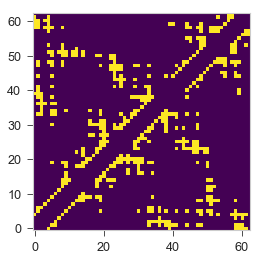

In [62]:
plt.imshow(native_contacts_table, origin=[0,0])